# Sentiment Analysis Benchmarking

Benchmark three sentiment analysis approaches:
1. Rule-based: VADER
2. Traditional ML: TF-IDF + Logistic Regression
3. Deep Learning SOTA: RoBERTa


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from transformers import pipeline
import torch

def set_seed(seed: int = 42):
    import random
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [9]:
reviews_df = pd.read_csv('./Reviews.csv')
sst_df = pd.read_csv(
    './training.1600000.processed.noemoticon.csv',
    names=['target','ids','date','flag','user','text'],
    encoding='latin-1'
)

sst_df = sst_df[sst_df.target.isin([0,4])].copy()
sst_df['sentiment'] = sst_df.target.map({0: 'negative', 4: 'positive'})

reviews_df = reviews_df[['Score','Text']].dropna()
reviews_df['sentiment'] = (
    reviews_df.Score
      .apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))
)
reviews_df = reviews_df[reviews_df.sentiment != 'neutral']

n_samples = 20000
n_sst = len(sst_df)
n_rev = len(reviews_df)
n_sst_sample = min(n_samples, n_sst)
n_rev_sample = min(n_samples, n_rev)

sst_sample = sst_df[['text','sentiment']].sample(
    n=n_sst_sample, random_state=42
)
reviews_sample = (
    reviews_df[['Text','sentiment']]
      .rename(columns={'Text':'text'})
      .sample(n=n_rev_sample, random_state=42)
)

data = pd.concat([sst_sample, reviews_sample], ignore_index=True)
X = data.text.values
y = data.sentiment.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Using {n_sst_sample} SST rows and {n_rev_sample} review rows; "
      f"total {len(data):,} examples.")


Using 10001 SST rows and 931 review rows; total 10,932 examples.


In [10]:
sid = SentimentIntensityAnalyzer()

def vader_predict(texts):
    preds = []
    for t in texts:
        score = sid.polarity_scores(t)['compound']
        preds.append('positive' if score >= 0 else 'negative')
    return preds

vader_preds = vader_predict(X_test)
print("VADER Accuracy:", accuracy_score(y_test, vader_preds))
print(classification_report(y_test, vader_preds))

VADER Accuracy: 0.6808413351623228
              precision    recall  f1-score   support

    negative       0.82      0.42      0.55      1031
    positive       0.64      0.92      0.75      1156

    accuracy                           0.68      2187
   macro avg       0.73      0.67      0.65      2187
weighted avg       0.72      0.68      0.66      2187



In [11]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)
ml_preds = clf.predict(X_test_tfidf)

print("ML Accuracy:", accuracy_score(y_test, ml_preds))
print(classification_report(y_test, ml_preds))

ML Accuracy: 0.7562871513488797
              precision    recall  f1-score   support

    negative       0.76      0.71      0.73      1031
    positive       0.76      0.79      0.78      1156

    accuracy                           0.76      2187
   macro avg       0.76      0.75      0.75      2187
weighted avg       0.76      0.76      0.76      2187



In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

device = 0 if torch.cuda.is_available() else -1

tokenizer = AutoTokenizer.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    use_fast=True
)
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment"
)

roberta = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
)

def roberta_predict(texts, batch_size=32):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        # ensure it's a Python list of strings
        if not isinstance(batch, list):
            batch = batch.tolist()

        # enforce truncation & padding
        results = roberta(
            batch,
            truncation=True,
            padding=True,
            max_length=512,
        )
        preds += [
            "positive" if r["label"].lower().startswith("positive") else "negative"
            for r in results
        ]
    return preds

X_test_list = X_test.tolist() if hasattr(X_test, "tolist") else list(X_test)
roberta_preds = roberta_predict(X_test_list)

print("RoBERTa Accuracy:", accuracy_score(y_test, roberta_preds))
print(classification_report(y_test, roberta_preds))


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


RoBERTa Accuracy: 0.47142203932327387
              precision    recall  f1-score   support

    negative       0.47      1.00      0.64      1031
    positive       0.00      0.00      0.00      1156

    accuracy                           0.47      2187
   macro avg       0.24      0.50      0.32      2187
weighted avg       0.22      0.47      0.30      2187



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


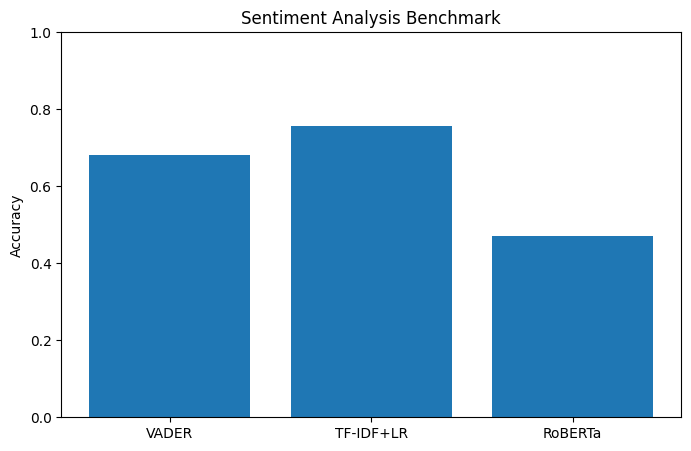

In [13]:
methods = ['VADER', 'TF-IDF+LR', 'RoBERTa']
scores = [
    accuracy_score(y_test, vader_preds),
    accuracy_score(y_test, ml_preds),
    accuracy_score(y_test, roberta_preds)
]

plt.figure(figsize=(8,5))
plt.bar(methods, scores)
plt.ylabel('Accuracy')
plt.title('Sentiment Analysis Benchmark')
plt.ylim(0, 1)
plt.show()

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [5]:
import pandas as pd

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=2,
    ignore_mismatched_sizes=True
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from datasets import Dataset
import pandas as pd

# Prepare the data frame to convert to hugging face dataset
train_df = pd.DataFrame({
    'text': X_train,
    'label': [1 if x == 'positive' else 0 for x in y_train]
})
test_df = pd.DataFrame({
    'text': X_test,
    'label': [1 if x == 'positive' else 0 for x in y_test]
})

# convert to a hugging face dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [20]:
from transformers import Trainer, TrainingArguments

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)


train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


training_args = TrainingArguments(
    output_dir="./roberta_finetuned_sentiment",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=1,
    report_to="none",
    logging_dir="./logs",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# fine tuning the model
trainer.train()


Map:   0%|          | 0/8745 [00:00<?, ? examples/s]

Map:   0%|          | 0/2187 [00:00<?, ? examples/s]

Step,Training Loss
500,0.425700
1000,0.264700
1500,0.158700


TrainOutput(global_step=1641, training_loss=0.26968277554044195, metrics={'train_runtime': 607.0428, 'train_samples_per_second': 43.218, 'train_steps_per_second': 2.703, 'total_flos': 1725679634342400.0, 'train_loss': 0.26968277554044195, 'epoch': 3.0})

In [22]:
trainer.save_model("./roberta_finetuned_sentiment")
tokenizer.save_pretrained("./roberta_finetuned_sentiment")


('./roberta_finetuned_sentiment/tokenizer_config.json',
 './roberta_finetuned_sentiment/special_tokens_map.json',
 './roberta_finetuned_sentiment/vocab.json',
 './roberta_finetuned_sentiment/merges.txt',
 './roberta_finetuned_sentiment/added_tokens.json',
 './roberta_finetuned_sentiment/tokenizer.json')

In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Loading the new finetuned model we just trained
finetuned_model_path = "./roberta_finetuned_sentiment"

tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path)
model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_path)

finetuned_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    padding=True,
    max_length=128
)


Device set to use cuda:0


In [24]:
X_test_list = X_test.tolist() if hasattr(X_test, "tolist") else list(X_test)

finetuned_preds_raw = finetuned_pipeline(X_test_list, batch_size=32)


In [25]:
finetuned_preds = [
    "negative" if pred["label"] == "LABEL_0" else "positive"
    for pred in finetuned_preds_raw
]


In [26]:
from sklearn.metrics import accuracy_score, classification_report

fine_tuned_roberta_acc = accuracy_score(y_test, finetuned_preds)

print("Fine-tuned RoBERTa Accuracy:", fine_tuned_roberta_acc)
print(classification_report(y_test, finetuned_preds))


Fine-tuned RoBERTa Accuracy: 0.8568815729309557
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      1031
    positive       0.87      0.86      0.86      1156

    accuracy                           0.86      2187
   macro avg       0.86      0.86      0.86      2187
weighted avg       0.86      0.86      0.86      2187



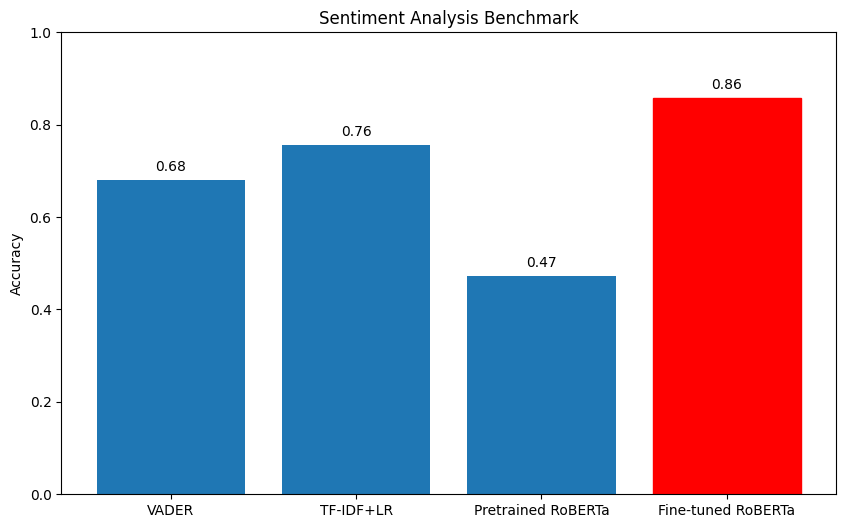

In [29]:
methods = ['VADER', 'TF-IDF+LR', 'Pretrained RoBERTa', 'Fine-tuned RoBERTa']
scores = [
    accuracy_score(y_test, vader_preds),
    accuracy_score(y_test, ml_preds),
    accuracy_score(y_test, roberta_preds),
    fine_tuned_roberta_acc
]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
bars = plt.bar(methods, scores)
bars[-1].set_color('red')
plt.ylabel('Accuracy')
plt.title('Sentiment Analysis Benchmark')
plt.ylim(0, 1)
for index, value in enumerate(scores):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center')
plt.show()
